In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
train = pd.read_csv('/content/drive/MyDrive/CSV/Training_Crossmatch.csv')


In [5]:
test = pd.read_csv('/content/drive/MyDrive/CSV/TestingCrossmatch.csv')

In [6]:
train.head()

,Filename,White Circular Patch,Contrast,Black Patch,Biffurcation,Termination,CID,Class,OCL_STD,LCS_STD,...,LCS,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2
0,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,30776.0,0.010333,0.999772,3804,333,107.771544,1,0.183448,0.321274,...,0.548794,0.613218,0.616894,0.125473,0.132002,0.325032,0.041322,0.355333,0.208121,0.006742
1,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,40066.5,0.003752,0.999955,5288,616,156.874296,1,0.149823,0.288940,...,0.549479,0.577886,0.515961,0.151181,0.125693,0.246866,0.056600,0.320952,0.221123,0.008132
2,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,49524.0,0.004532,0.999884,4861,361,218.001356,1,0.157811,0.320884,...,0.501499,0.532120,0.626022,0.130306,0.118022,0.269136,0.065313,0.317784,0.267345,0.007559
3,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,10324.0,0.047750,0.998029,1661,337,212.954369,1,0.143613,0.323289,...,0.519335,0.341780,0.591813,0.066328,0.097421,0.292708,0.045235,0.315834,0.116780,0.003814
4,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,11792.0,0.029279,0.999124,2026,347,181.324385,1,0.163183,0.324478,...,0.511962,0.477842,0.595702,0.074459,0.149858,0.316726,0.039893,0.328637,0.120669,0.004112


In [7]:
target = 'Class'
if "Set"  in train.columns:
    train.drop(["Set"], axis = 1)
train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))    
train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

In [8]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Filename 2977
Class 2
Set 2


In [9]:
train.head()

,Filename,White Circular Patch,Contrast,Black Patch,Biffurcation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1467,30776.0,0.010333,0.999772,3804,333,107.771544,1,0.183448,0.321274,...,0.613218,0.616894,0.125473,0.132002,0.325032,0.041322,0.355333,0.208121,0.006742,0
1,1468,40066.5,0.003752,0.999955,5288,616,156.874296,1,0.149823,0.288940,...,0.577886,0.515961,0.151181,0.125693,0.246866,0.056600,0.320952,0.221123,0.008132,0
2,1469,49524.0,0.004532,0.999884,4861,361,218.001356,1,0.157811,0.320884,...,0.532120,0.626022,0.130306,0.118022,0.269136,0.065313,0.317784,0.267345,0.007559,0
3,1470,10324.0,0.047750,0.998029,1661,337,212.954369,1,0.143613,0.323289,...,0.341780,0.591813,0.066328,0.097421,0.292708,0.045235,0.315834,0.116780,0.003814,0
4,1471,11792.0,0.029279,0.999124,2026,347,181.324385,1,0.163183,0.324478,...,0.477842,0.595702,0.074459,0.149858,0.316726,0.039893,0.328637,0.120669,0.004112,0


In [10]:
train.loc[train[target]==0, target] = "classZero"
train.loc[train[target]==1, target] = "classOne"

In [11]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [12]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

Device used : cpu


In [13]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

In [14]:
X_train[0]

array([1.46700000e+03, 3.07760000e+04, 1.03334550e-02, 9.99772299e-01,
       3.80400000e+03, 3.33000000e+02, 1.07771544e+02, 1.83447637e-01,
       3.21274300e-01, 2.84277750e-01, 9.07647963e+03, 3.56390888e-01,
       1.30293305e+00, 2.73277536e-01, 7.57936508e-01, 3.71390116e+01,
       2.43524881e+02, 4.14784012e-01, 5.48794275e-01, 6.13217592e-01,
       6.16894174e-01, 1.25472855e-01, 1.32001804e-01, 3.25032298e-01,
       4.13218420e-02, 3.55333434e-01, 2.08120601e-01, 6.74196300e-03])

In [15]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [16]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #aug, None
    )
    save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 0.80558 | train_auc: 0.47029 | valid_auc: 0.46434 |  0:00:00s
epoch 1  | loss: 0.53863 | train_auc: 0.54062 | valid_auc: 0.5511  |  0:00:00s
epoch 2  | loss: 0.46401 | train_auc: 0.64113 | valid_auc: 0.63446 |  0:00:00s
epoch 3  | loss: 0.39005 | train_auc: 0.81146 | valid_auc: 0.80779 |  0:00:01s
epoch 4  | loss: 0.33076 | train_auc: 0.82103 | valid_auc: 0.81733 |  0:00:01s
epoch 5  | loss: 0.31456 | train_auc: 0.82207 | valid_auc: 0.8025  |  0:00:01s
epoch 6  | loss: 0.27528 | train_auc: 0.77289 | valid_auc: 0.75337 |  0:00:01s
epoch 7  | loss: 0.27306 | train_auc: 0.78859 | valid_auc: 0.77623 |  0:00:01s
epoch 8  | loss: 0.23858 | train_auc: 0.81638 | valid_auc: 0.7969  |  0:00:02s
epoch 9  | loss: 0.22556 | train_auc: 0.83021 | valid_auc: 0.80641 |  0:00:02s
epoch 10 | loss: 0.19191 | train_auc: 0.83767 | valid_auc: 0.8157  |  0:00:02s
epoch 11 | loss: 0.18347 | train_auc: 0.83961 | valid_auc: 0.82068 |  0:00:02s
epoch 12 | loss: 0.17634 | train_auc: 0.84819 | vali

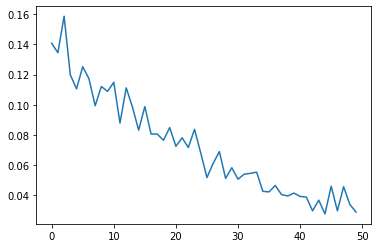

In [17]:
plt.plot(clf.history['loss'])

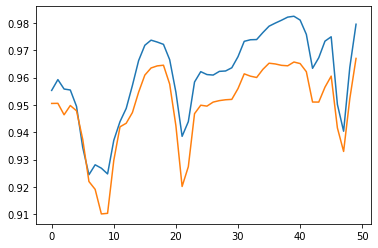

In [18]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

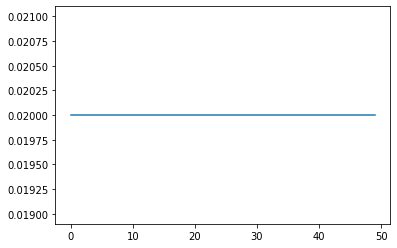

In [19]:
plt.plot(clf.history['lr'])

In [21]:
target = 'Class'

In [22]:
if "Set" in test.columns:
  test.drop(['Set'], axis = 1)
test["Set"] = "test"
test_indices = test[test.Set=="test"].index

In [23]:
test_indices

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940],
           dtype='int64', length=2941)

In [24]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,5292.0,0.166200,0.976471,1509,403,332.053514,1,0.082090,0.160900,...,0.668878,0.450442,0.659029,0.053521,0.092457,0.058338,0.082080,0.097579,0.018765,test
1,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,4175.5,0.098199,0.989966,1339,453,265.142266,1,0.075764,0.141661,...,0.656728,0.420273,0.581228,0.052430,0.076413,0.052317,0.084231,0.067239,0.017077,test
2,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,5829.0,0.054095,0.996549,1679,472,293.976355,1,0.096840,0.210623,...,0.672784,0.417944,0.529954,0.046736,0.119511,0.051440,0.077678,0.067060,0.015679,test
3,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,3193.5,0.024822,0.998801,1902,340,289.341544,1,0.119394,0.230169,...,0.709769,0.400578,0.283677,0.063880,0.145236,0.038813,0.079486,0.053488,0.010148,test
4,I:\LivDet\LivDet2015\Testing\CrossMatch\Live\0...,3132.0,0.129463,0.985666,1132,296,314.832926,1,0.129622,0.254241,...,0.732113,0.436506,0.339123,0.079128,0.228858,0.031483,0.107797,0.045660,0.011812,test


In [25]:
nunique = test.nunique()
types = test.dtypes

categorical_columns = []
categorical_dims =  {}
for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

Filename 2941
Class 2
Set 1


In [26]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1443,5292.0,0.166200,0.976471,1509,403,332.053514,1,0.082090,0.160900,...,0.668878,0.450442,0.659029,0.053521,0.092457,0.058338,0.082080,0.097579,0.018765,0
1,1444,4175.5,0.098199,0.989966,1339,453,265.142266,1,0.075764,0.141661,...,0.656728,0.420273,0.581228,0.052430,0.076413,0.052317,0.084231,0.067239,0.017077,0
2,1445,5829.0,0.054095,0.996549,1679,472,293.976355,1,0.096840,0.210623,...,0.672784,0.417944,0.529954,0.046736,0.119511,0.051440,0.077678,0.067060,0.015679,0
3,1446,3193.5,0.024822,0.998801,1902,340,289.341544,1,0.119394,0.230169,...,0.709769,0.400578,0.283677,0.063880,0.145236,0.038813,0.079486,0.053488,0.010148,0
4,1447,3132.0,0.129463,0.985666,1132,296,314.832926,1,0.129622,0.254241,...,0.732113,0.436506,0.339123,0.079128,0.228858,0.031483,0.107797,0.045660,0.011812,0


In [27]:

test.loc[test[target]==0, target] = "classZero"
test.loc[test[target]==1, target] = "classOne"

In [28]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1443,5292.0,0.166200,0.976471,1509,403,332.053514,classOne,0.082090,0.160900,...,0.668878,0.450442,0.659029,0.053521,0.092457,0.058338,0.082080,0.097579,0.018765,0
1,1444,4175.5,0.098199,0.989966,1339,453,265.142266,classOne,0.075764,0.141661,...,0.656728,0.420273,0.581228,0.052430,0.076413,0.052317,0.084231,0.067239,0.017077,0
2,1445,5829.0,0.054095,0.996549,1679,472,293.976355,classOne,0.096840,0.210623,...,0.672784,0.417944,0.529954,0.046736,0.119511,0.051440,0.077678,0.067060,0.015679,0
3,1446,3193.5,0.024822,0.998801,1902,340,289.341544,classOne,0.119394,0.230169,...,0.709769,0.400578,0.283677,0.063880,0.145236,0.038813,0.079486,0.053488,0.010148,0
4,1447,3132.0,0.129463,0.985666,1132,296,314.832926,classOne,0.129622,0.254241,...,0.732113,0.436506,0.339123,0.079128,0.228858,0.031483,0.107797,0.045660,0.011812,0


In [29]:
unused_feat = ['Set']

features = [ col for col in test.columns if col not in unused_feat+[target]] 

In [30]:
features

['Filename',
 'White Circle Patch',
 'Contrast',
 'Black Patch',
 'Biffercation',
 'Termination',
 'CID',
 'OCL_STD',
 'LCS_STD',
 'OFL_STD',
 'RPS',
 'FDA_STD',
 'RVU',
 'GABOR_STD',
 'GABORSHEN',
 'SIGMA',
 'MEAN',
 'OCL',
 'LCS',
 'OFL',
 'FDA',
 'GABOR',
 'OCL_STD2',
 'LCS_STD2',
 'OFL_STD2',
 'FDA_STD2',
 'RVU_STD2',
 'GABOR_STD2']

In [31]:
X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]

In [32]:
X_test[1]

array([1.44400000e+03, 4.17550000e+03, 9.81991470e-02, 9.89966475e-01,
       1.33900000e+03, 4.53000000e+02, 2.65142266e+02, 7.57639030e-02,
       1.41661272e-01, 3.15186567e-01, 9.89956768e+03, 1.47372170e-01,
       4.57115922e-01, 9.90511553e-01, 9.57654723e-01, 6.30754902e+01,
       2.28090862e+02, 8.41039824e-01, 8.18791155e-01, 6.56727967e-01,
       4.20272848e-01, 5.81227629e-01, 5.24298650e-02, 7.64134380e-02,
       5.23168300e-02, 8.42310460e-02, 6.72386550e-02, 1.70767050e-02])

In [33]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.9670165220732472
FINAL TEST SCORE : 0.9695537686191893


In [34]:
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [35]:
clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classZero', 'classZero',
       'classZero'], dtype='<U9')

In [36]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [37]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [38]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE  : {loaded_test_auc}")

FINAL TEST SCORE  : 0.9695537686191893


In [39]:
assert(test_auc == loaded_test_auc)

In [40]:
loaded_clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classZero', 'classZero',
       'classZero'], dtype='<U9')

In [41]:
clf.feature_importances_

array([4.88202705e-02, 1.14204736e-03, 9.25384546e-04, 4.22364742e-04,
       2.67081428e-01, 1.18703544e-01, 8.61300043e-02, 2.77298179e-02,
       1.85627325e-03, 3.22146228e-02, 3.03449594e-07, 2.15655141e-02,
       1.58443691e-03, 3.64650134e-02, 9.53028505e-04, 1.11902595e-01,
       8.16665917e-04, 4.91334675e-02, 5.28103367e-09, 3.38720511e-05,
       1.12739059e-01, 2.72093046e-02, 2.54273873e-02, 1.37759569e-02,
       1.08764165e-02, 1.55388165e-04, 2.19803934e-03, 1.37788746e-04])

In [42]:
explain_matrix, masks = clf.explain(X_test)

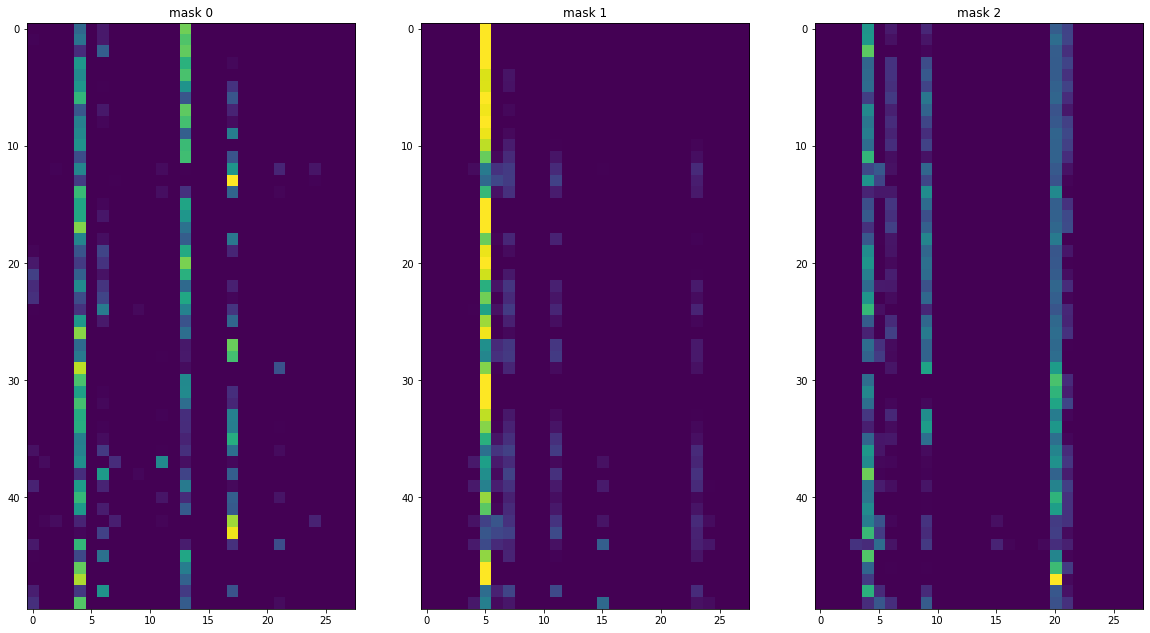

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")